# Introdução 

Em 15 de abril de 1912, durante sua viagem inaugural, o Titanic afundou depois de colidir com um iceberg, matando 1502 de 2224 passageiros e tripulantes (fonte: https://pt.wikipedia.org/wiki/Naufr%C3%A1gio_do_RMS_Titanic). Algumas coisas são interessantes para notar antes de começar:

    - 32% das pessoas sobreviveram nessa tragédia
    - Uma das razões pelas quais o naufrágio causou tanto mortos foi que não havia botes 
    salva-vidas suficientes para os passageiros e a tripulação.
    - Embora houvesse algum elemento de sorte envolvido na sobrevivência do naufrágio, 
    alguns grupos de pessoas tinham maior probabilidade de sobreviver do que outros, como 
    mulheres, crianças e a classe alta.
    
A meta desse exercicio é de criar um algoritmo que prevê, com as informações do passageiro, a probabilidade dele morrer ou não no Titanic. 

Para fazer isso, eu utilizei o linguagem Python. Os dados utilizados para treinar o algoritmo se chamam "train.csv"; e os dados de previsão se chamam "test.csv". Os dados "test.csv" são disponiveis nesse site: https://www.kaggle.com/c/titanic/data.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# random 
import random

## Carregando os dados

Os dados são carregados em um pandas DataFrame. 

In [2]:
test_df = pd.read_csv("./test.csv") # Test data
test_kaggle_df = test_df.copy()
train_df = pd.read_csv("./train.csv") # Train data
combine = [train_df, test_kaggle_df]
train_df_example = train_df.copy() # Data use to plot after modification of train data 

# Descrição dos dados

Os dados disponiveis para cada pessoa no Titanic são resumidos abaixo.

In [3]:
print(train_df.columns.values) # Name of the columns 
train_df.head() # Plot of the data

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Os dados podem ser divididos em três tipos:

    - Categorias:
    
        > Pclass: Esse dado diz se o passageiro está na primeira, segunda ou terceira classe no navio. 
        > Survided: Esse dado diz se o passageiro sobrevive ou não
        > Sex: Esse dado informa qual é o sexo do passageiro
        > Embarked: Esse dado informa sobre o porto de embarcação do passageiro (S = 
        Southampton, C = Cherbourg, Q = Quimpert)
        
    - Numérico:
    
        > Age: Esse dado informa a idade do passageiro ao embarcar no navio
        > SibSp: Número de irmãos e esposa/marido no navio
        > Parch: Número de pais no Titanic no navio
        > Fare: Esse dado informa sobre o preço que o passageiro pagou para participar da 
        viagem
        
    - Palavras:
    
        > Name: Nome do passageiro
        > Ticket: Número de passagens comprado pelo passageiro
        > Cabin: Número da cabine onde o passageiro dormiu
        

# Enumeração de dados incompletos

Alguns dados são incompletos. No seguinte código, o número de dados incompletos (NaN) em cada coluna são calculados. 

In [4]:
train_df.info()
print('_'*40)
test_kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

As colunas "Age" & "Cabin" são incompletas para os dados de teste e de treinamento. Além disso, falta um dado "Fare" nos dados de teste e dois dados "Embarked" nos dados de treinamento.

# Análise rápida dos dados

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Essa matriz resume os dados numericos. As observações da analise da matriz são: 

    - A média de sobrevivência é de 38%, está próxima dos 32% calculados com os verdadeiros 
    dados da catástrofe 
    - Muitas pessoas (>75%) viajam sem familia. 
    - O preço aumenta muito rapidamente para as passagens mais caras (passa de 30 a 500 
    para as 25% passagens mais caras)
    - Têm poucas pessoas idosas (>65 anos)
    - Mais de 50% das pessoas estão na terceira classe

In [6]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Carter, Miss. Lucile Polk",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


Essa matriz resume os dados categoriais e com palavras. As observações da analise da matriz são: 

    - Cada nome é único, podemos concluir que não têm duplicata
    - Têm 2 tipos de sexos, masculino e feminino, sendo que 65% são homens 
    - A maior parte das pessoas embarcaram em Southampton (72%)
    
Os dados não parecem ter grande problemas exceto alguns dados incompletos. 

# Suposições baseadas na análise de dados


Antes de começar o problema, suposições podem ser feitas sobre a utilização dos dados para trainar o modelo, todas essas suposições vão ser validadas ou invalidadas depois: 

    - Pclass: As pessoas na classe alta devem ter mais chance de sobreviver. Por isso, os 
    dados "Pclass" parecem ser importantes para treinar o modelo
    - Name: O titulo (ex: "Doctor", "Captain" etc..) das pessoas pode ser uma informação 
    decisiva. Por isso, podemos extrair dados importantes dos nomes
    - Sex: Podemos imaginar facilmente que as chances de sobrevivencia das mulheres é mais 
    alta que a dos homens
    - Age: A idade das pessoas parece ser uma informação decisiva também. Por isso, temos 
    que completar esses dados para os utilizar 
    - SibSp/Parch: A informação pode ser interessante, a relação entre as chances de 
    sobreviver e esses dados têm que ser estudada
    - Ticket: A informação não parece interessante. 
    - Fare: O preço da passagem poder ser decisivo para treinar o modelo. De fato, as 
    pessoas que pagam mais têm mais chance de sobreviver
    - Cabin: Faltam muitos dados de "Cabin" para os utilizar 
    - Embarked: Essas informações podem ser interessantes, e têm que ser estudadas 

# Análise do impacto dos dados e incorporação no modelo

### Modificação dos dados "Age"

##### Correlação entre a idade e as chances de sobreviver

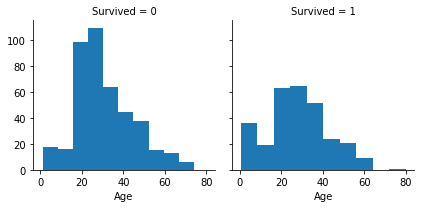

In [7]:
train_df_normalized = train_df.copy()

g = sns.FacetGrid(train_df_normalized, col='Survived')
g.map(plt.hist, 'Age', bins=10)

Algumas coisas podem ser obervadas:

    - As crianças (Age<10) têm mais chance de soberviver
    - A maior parte das pessoas que morrem têm entre 15 e 40 anos
    
As conclusões feitas sobre Age são as seguintes:

    - Os dados "Age" são correlacionados com as chances de sobrevivencia 
    - Os dados "Age" vão ser preenchidas e cortadas em cinco fatias

##### Incorporação no modelo

A primeira etapa é de preencher os dados de idade. Para fazer isso, o método escolhido é de preencher com uma idade aleatória calculada pela maquina entre a média das idades menos o desvio padrão e a média mais o desvio padrão.

In [8]:
for dataset in combine:
    dataset.loc[(dataset.Age.isnull()),'Age'] = random.uniform(dataset.Age.mean() - \
            dataset.Age.std() , dataset.Age.mean() + dataset.Age.std()) 

    dataset['Age'] = dataset['Age'].astype(int)

train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,38,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,NaN,Q


A proxima etapa é de cortar os dados de idade em cinco fatias para ver se essas fatias são correlacionadas com as chances de sobrevivencia ou não. 

In [9]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False). \
mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.370690
2,"(32.0, 48.0]",0.349862
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


A correlação é clara, portanto, as fatias de idade são uma informação útil para o modelo. 

In [10]:
#AGE BAND SOLUTION

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_kaggle_df]

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,1,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,2,0,0,373450,8.0500,NaN,S


## Analise dos dados "Pclass"

##### Correlação entre a classe e as chances de sobreviver 

In [11]:
print(train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False)\
    .mean().sort_values(by='Survived', ascending=False))

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


/home/farfadet/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


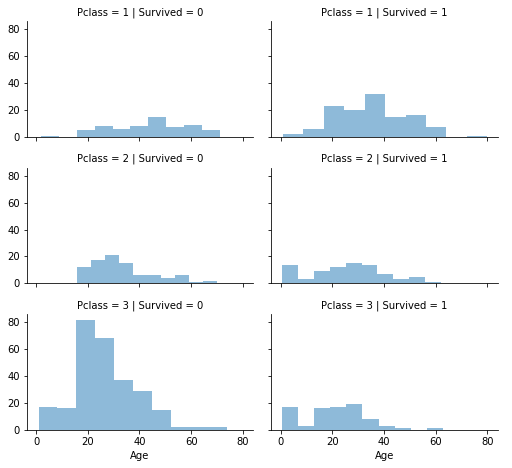

In [12]:
grid = sns.FacetGrid(train_df_example, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=10)
grid.add_legend();

A terceira classe é a com mais pessoas e a maioria morre. Além disso, a maior parte das pessoas que estão na primeira classe sobrevivem. Portanto, os dados "Pclass" são correlacionadas com as chances de sobrevivencia e eles devem ser utilizados para treinar o modelo. 

## Modificação dos dados "Sex"

##### Correlação entre o sexo e as chances de sobreviver

In [13]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False)\
    .mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


As mulheres têm mais chance de sobreviver (74%) que os homens (19%). Os dados "Sex" são correlacionados com as chances de sobrevivencia e devem ser utilizados.

##### Incorporação no modelo

Para tratar mais facilmente esses dados, a valor 1 é atribuido para as mulherer e a valor 0 para os homens.

In [14]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,8.0500,NaN,S


## Criação dos dados "Title"


##### Correlação entre o titulo da pessoa e as chances de sobreviver

A primeira etapa é de extrair e listar os titulos das pessoas no navio. 

In [15]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


Tem titulos que são raros (com menos de 6 pessoas), eles não são revelantes para o problema porque não tem bastante informações. Então, todos esses titulos serão agrupados em uma nova coluna que se chama "Rare". Os outros (ie "Mr", "Miss", "Master", "Mrs") podem ser interessantes sozinhos porque tem mais informações.

In [16]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# Measure of the % of survivors vs title 

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Esses valores mostram que o titulo das pessoas pode ser utilizado para treinar o modelo. 

Uma grande parte dos titulos "Rare" são titulos militares o medicais que representam a equipe do navio. De fato, a tripulação morre massivamente (20% salvos), isso explica a valor de sobrevivencia baixo dessa categoria.     

##### Incorporação no modelo

In [17]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,8.0500,NaN,S,1


In [18]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_kaggle_df = test_kaggle_df.drop(['Name','PassengerId'], axis=1)
combine = [train_df, test_kaggle_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,0,1,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,1,2,1,0,PC 17599,71.2833,C85,C,3
2,1,3,1,1,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,1,1,1,2,1,0,113803,53.1000,C123,S,3
4,0,3,0,2,0,0,373450,8.0500,NaN,S,1


## Criação dos dados "IsAlone"

##### Correlação entre o tamanho da familia no navio e as chances de sobreviver

As chances de sobrevivencia são calculadas em função de "SibSp" + "Parch". 

In [19]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False)\
    .mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


A conexão entre o tamanho da familia e as chances de sobrevivencia não são claras. De fato, parece que ter uma pequena familia (< 4 pessoas) é melhor para sobreviver do que estar sozinho. Mas, parece ser melhor estar sozinho do que ter uma familia grande (> 4 pessoas). 

In [20]:
dataset['FamilySize'].value_counts()

0     253
1      74
2      57
3      14
4       7
10      4
6       4
5       3
7       2
Name: FamilySize, dtype: int64

O numero de pessoas com uma familia grande é pequeno. Então, pode ser interessante de tentar uma outra caracteristica que representa se a pessoa está sozinha ou não.

##### Correlação entre estar sozinho ou acompanhado e as chances de sobreviver

In [21]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 0, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Essa caracteristica parece melhor para treinar o modelo que o tamanho da familia. Portanto, essa caracteristica vai ser incorporada no modelo. 

##### Incorporação no modelo

In [22]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_kaggle_df = test_kaggle_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_kaggle_df]

train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,IsAlone
0,0,3,0,1,A/5 21171,7.2500,NaN,S,1,0
1,1,1,1,2,PC 17599,71.2833,C85,C,3,0
2,1,3,1,1,STON/O2. 3101282,7.9250,NaN,S,2,1
3,1,1,1,2,113803,53.1000,C123,S,3,0
4,0,3,0,2,373450,8.0500,NaN,S,1,1


## Modificação dos dados "Fare"

#### Preenchido dos dados "Fare" 

O dado que falta nos dados de teste para "Fare" é preechido com o mediano. 

In [23]:
test_kaggle_df['Fare'].fillna(test_kaggle_df['Fare'].dropna().median(), inplace=True)
test_kaggle_df.head()

,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,IsAlone
0,3,0,2,330911,7.8292,NaN,Q,1,1
1,3,1,2,363272,7.0000,NaN,S,3,0
2,2,0,3,240276,9.6875,NaN,Q,1,1
3,3,0,1,315154,8.6625,NaN,S,1,1
4,3,1,1,3101298,12.2875,NaN,S,3,0


##### Correlação entre o preço pago na passagem e as chances de sobreviver

/home/farfadet/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


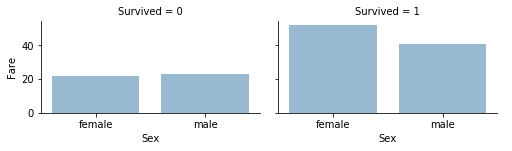

In [24]:
grid = sns.FacetGrid(train_df_example, col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

As pessoas que gastam mais dinheiro para a passagem têm mais chance de sobreviver de acordo com esse grafico. 

Para melhorar esses dados, eles podem ser cortados em quatro partes, como fizemos para os dados de idade. 

In [25]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False)\
    .mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Esses resultados mostram que as partes de Fare são conectadas com as chances de sobrevivencia. Portanto, essa caracteristica vai ser utilizada para treinar o modelo. 

##### Incorporação no modelo

In [26]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_kaggle_df]
    
train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,IsAlone
0,0,3,0,1,A/5 21171,0,NaN,S,1,0
1,1,1,1,2,PC 17599,3,C85,C,3,0
2,1,3,1,1,STON/O2. 3101282,1,NaN,S,2,1
3,1,1,1,2,113803,3,C123,S,3,0
4,0,3,0,2,373450,1,NaN,S,1,1


## Modificação dos dados "Embarked"

#### Preenchendo os dados "Embarked" 

Faltam dois dados na coluna "Embarked" na matriz "train_df". 

Essas partes incompletas vão ser preenchidas com a valor mais comum de "Embarked".

In [27]:
freq_port = train_df.Embarked.dropna().mode()[0]

print("The most frequent value of 'Embarked' is {}".format(freq_port))

The most frequent value of 'Embarked' is S


In [28]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

##### Correlação entre o local de embarque e as chances de sobreviver

In [29]:
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).\
    mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


/home/farfadet/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/farfadet/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/farfadet/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/farfadet/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.redu

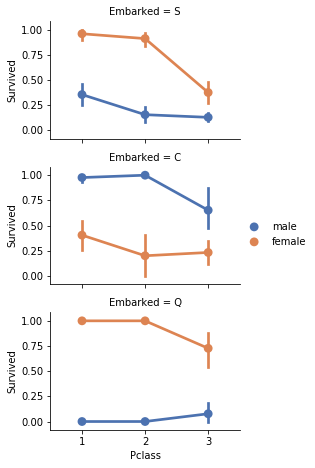

In [30]:
grid = sns.FacetGrid(train_df_example, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

O primeiro resultado mostra que a taxa de sobrevivência muda com os dados "Embarked", particularmente com a valor "Cherbourg". Além disso, os graficos confirmam isso. Portanto, os dados "Embarked" devem ser utilizados para treinar o modelo. 

##### Incorporação no modelo

In [31]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,IsAlone
0,0,3,0,1,A/5 21171,0,NaN,0,1,0
1,1,1,1,2,PC 17599,3,C85,1,3,0
2,1,3,1,1,STON/O2. 3101282,1,NaN,0,2,1
3,1,1,1,2,113803,3,C123,0,3,0
4,0,3,0,2,373450,1,NaN,0,1,1


## Supressão dos dados "Cabins" e "Ticket"

In [32]:
print("Before", train_df.shape, test_kaggle_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_kaggle_df = test_kaggle_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_kaggle_df]

"After", train_df.shape, test_kaggle_df.shape, combine[0].shape, combine[1].shape

Before (891, 10) (418, 9) (891, 10) (418, 9)


('After', (891, 8), (418, 7), (891, 8), (418, 7))

Agora os dados são prontos para treinar um modelo e prever a solução necessária.

# Modele, preveja e resolva

## A construção do modelo

#### Um primeiro modelo basico

A primeira etapa é de preparar os dados para o modelo. Para treinar e avaliar o modelo, os dados "train_df" vão ser cortados em dois. 70% vão ser utilizados para o treinar e 30% para o avaliar.

In [33]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_kaggle_df.copy()

X_train, X_validation, y_train, y_validation = train_test_split(\
    X_train, Y_train, test_size=0.3, random_state=0)


Para o primeiro modelo, vamos escolher um modelo de Regressão Logisitica sem modificar os hiperparâmetros. 

O modelos é avaliado com as medidas seguintes: 
    
    - Retidão: A porcentagem de bom resultados previstos
    - F1 score: 2*exatidão*retorno/(exatidão+retorno)
    
Essas medidas são calculadas com os dados de treinamento e de validação para serem comparados. Isso é feito para verificar que o modelo não é sobreajustado.

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_validation)

Y_train_pred = logreg.predict(X_train)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_LR = f1_score(y_validation,Y_pred)
score_train_LR = f1_score(y_train, Y_train_pred)

justesse_validation_LR = 1- (abs(y_validation-Y_pred).mean())
justesse_train_LR = 1- (abs(y_train-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_LR*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_LR*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(justesse_train_LR*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(justesse_validation_LR*100))


The pourcentage of true positive is 0.27238805970149255
The pourcentage of true negative is 0.5074626865671642
The pourcentage of false positive is 0.11940298507462686
The pourcentage of false negative is 0.10074626865671642
--------------------------------------
The F1 score of the model with the train data is 75.27352297592998
The F1 score of the model with the validation data is 71.21951219512195
--------------------------------------
The mean accuracy of the model with the train data is 81.86195826645265
The mean accuracy of the model with the validation data is 77.98507462686567


/home/farfadet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.015437
5,Title,0.542930
4,Embarked,0.327524
6,IsAlone,0.104926
2,Age,-0.028111
3,Fare,-0.156706
0,Pclass,-1.041696


#### Comparação entre quatro tipos de modelos

Quatro tipos de modelos vão ser experimentados para saber qual é o mais adequado para resolver esse problema. A lista dos modelos testados é a seguinte (todos são otimizados com os sobreajustados): 

    - Regressão Logistica
    - k vizinhos mais próximos
    - Máquina de vetores de suporte
    - Floresta aleatoria
    
    

In [36]:
logreg = LogisticRegression(C=0.05)
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_validation)

Y_train_pred = logreg.predict(X_train)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))


print("--------------------------------------")

score_validation_LR = f1_score(y_validation,Y_pred)
score_train_LR = f1_score(y_train, Y_train_pred)

justesse_validation_LR = 1- (abs(y_validation-Y_pred).mean())
justesse_train_LR = 1- (abs(y_train-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_LR*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_LR*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(justesse_train_LR*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(justesse_validation_LR*100))


The pourcentage of true positive is 0.2537313432835821
The pourcentage of true negative is 0.5373134328358209
The pourcentage of false positive is 0.08955223880597014
The pourcentage of false negative is 0.11940298507462686
--------------------------------------
The F1 score of the model with the train data is 74.71526195899771
The F1 score of the model with the validation data is 70.83333333333334
--------------------------------------
The mean accuracy of the model with the train data is 82.18298555377207
The mean accuracy of the model with the validation data is 79.10447761194031


/home/farfadet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [37]:
# RANDOM FOREST MODEL 

random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_validation)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)

Y_train_pred = random_forest.predict(X_train)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_RF = f1_score(y_validation,Y_pred)
score_train_RF = f1_score(y_train, Y_train_pred)

justesse_validation_RF = 1- (abs(y_validation-Y_pred).mean())
justesse_train_RF = 1- (abs(y_train-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_RF*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_RF*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(justesse_train_RF*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(justesse_validation_RF*100))


The pourcentage of true positive is 0.2873134328358209
The pourcentage of true negative is 0.5447761194029851
The pourcentage of false positive is 0.08208955223880597
The pourcentage of false negative is 0.08582089552238806
--------------------------------------
The F1 score of the model with the train data is 83.08351177730192
The F1 score of the model with the validation data is 77.38693467336684
--------------------------------------
The mean accuracy of the model with the train data is 87.31942215088282
The mean accuracy of the model with the validation data is 83.2089552238806


In [38]:
# Support Vector Machines

svc = SVC(C=200,degree=5)
svc.fit(X_train, y_train)

Y_pred = svc.predict(X_validation)
Y_train_pred = svc.predict(X_train)

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_svc = f1_score(y_validation,Y_pred)
score_train_svc = f1_score(y_train, Y_train_pred)

justesse_validation_svc = 1- (abs(y_validation-Y_pred).mean())
justesse_train_svc = 1- (abs(y_train-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_svc*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_svc*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(justesse_train_svc*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(justesse_validation_svc*100))


The pourcentage of true positive is 0.27611940298507465
The pourcentage of true negative is 0.5708955223880597
The pourcentage of false positive is 0.055970149253731345
The pourcentage of false negative is 0.09701492537313433
--------------------------------------
The F1 score of the model with the train data is 82.37885462555066
The F1 score of the model with the validation data is 78.3068783068783
--------------------------------------
The mean accuracy of the model with the train data is 87.15890850722312
The mean accuracy of the model with the validation data is 84.70149253731343


/home/farfadet/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [39]:
#KNN

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_validation)
Y_train_pred = knn.predict(X_train)

#acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
#acc_knn

matrix_confusion = confusion_matrix(y_validation,Y_pred).ravel()
matrix_confusion_normalized = matrix_confusion / matrix_confusion.astype(np.float).sum()

#print([tn, fp, fn, tp])

print("The pourcentage of true positive is {}".format(matrix_confusion_normalized[3]))
print("The pourcentage of true negative is {}".format(matrix_confusion_normalized[0]))
print("The pourcentage of false positive is {}".format(matrix_confusion_normalized[1]))
print("The pourcentage of false negative is {}".format(matrix_confusion_normalized[2]))

print("--------------------------------------")

score_validation_knn = f1_score(y_validation,Y_pred)
score_train_knn = f1_score(y_train, Y_train_pred)

justesse_validation_knn = 1- (abs(y_validation-Y_pred).mean())
justesse_train_knn = 1- (abs(y_train-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_knn*100))
print("The F1 score of the model with the validation data is {}"\
    .format(score_validation_knn*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(justesse_train_knn*100))
print("The mean accuracy of the model with the validation data is {}"\
    .format(justesse_validation_knn*100))


The pourcentage of true positive is 0.26865671641791045
The pourcentage of true negative is 0.5335820895522388
The pourcentage of false positive is 0.09328358208955224
The pourcentage of false negative is 0.1044776119402985
--------------------------------------
The F1 score of the model with the train data is 78.58719646799118
The F1 score of the model with the validation data is 73.09644670050761
--------------------------------------
The mean accuracy of the model with the train data is 84.43017656500803
The mean accuracy of the model with the validation data is 80.22388059701493


In [40]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Random Forest','Linear SVC',],
    'F1 Score': [score_validation_knn*100, score_validation_LR*100, score_validation_RF*100, 
              score_validation_svc*100],
    'Accuracy': [justesse_validation_knn*100, justesse_validation_LR*100,
                 justesse_validation_RF*100, justesse_validation_svc*100]})
models.sort_values(by='F1 Score', ascending=False)

,Model,F1 Score,Accuracy
3,Linear SVC,78.306878,84.701493
2,Random Forest,77.386935,83.208955
0,KNN,73.096447,80.223881
1,Logistic Regression,70.833333,79.104478


O modelo da Máquina de vetores de suporte parece ser o mais adequado para esse problema.

#### Previsão da sobrevivencia das pessoas desconhecidas

O modelo está pronto para resolver o problema do Titanic com um arquivo de dados desconhecidos.

In [41]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_kaggle_df.copy()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)
Y_train_pred = svc.predict(X_train)

score_train_svc = f1_score(Y_train, Y_train_pred)
justesse_train_svc = 1- (abs(Y_train-Y_train_pred).mean())

print("The F1 score of the model with the train data is {}"\
    .format(score_train_svc*100))

print("--------------------------------------")

print("The mean accuracy of the model with the train data is {}"\
    .format(justesse_train_svc*100))

The F1 score of the model with the train data is 81.875
--------------------------------------
The mean accuracy of the model with the train data is 86.98092031425365


/home/farfadet/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [42]:
Y_final = X_test.copy()
Y_final["Forecast Survived"] = Y_pred

Y_final.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Forecast Survived
0,3,0,2,0,2,1,1,0
1,3,1,2,0,0,3,0,0
2,2,0,3,1,2,1,1,0
3,3,0,1,1,0,1,1,0
4,3,1,1,1,0,3,0,1


# Conclusão 


A partir de dados sobre os passageiros da catastrofe do Titanic, conseguimos construir um modelo robusto e preciso, que pode prever as chances de morrer nessa tragedia. Para fazer isso, limpamos os dados, escolhemos os dados úteis & utilizamos o algoritmo mais adequados com nosso problema. 

In [47]:
df_final = pd.DataFrame(test_df.PassengerId)

df_final["Survived"] = Y_pred

In [48]:
df_final

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [49]:
df_final.to_csv("submission.csv")